In [1]:
import importlib

import numpy as np
import ParseING11 as parse
import check_configs as configcheck


importlib.reload(parse)
importlib.reload(configcheck)

<module 'check_configs' from 'c:\\Users\\brewster\\Desktop\\CUDA Cowan  redone\\check_configs.py'>

In [2]:
# aligning the scraped data with predicitions of amounts of F, G, zeta etc 
def check(filename):
    parseddata = parse.main(filename)

    alignment = []
    # values for our 
    for key, value in parseddata[1].items():
        configdict = configcheck.main(key.split()[1])
        print(key, len(value), sum(configdict.values())) #Number of output values scraped, number of output values predicted
        print(key, value, configdict)
        alignment.append(len(value) == sum(configdict.values())) # list of bools for checked configurations

    return alignment

for i in range(1,8):
    filename = f"ING11_{i}.txt"
    alignment = check(filename)
    print(filename, alignment, "\n")


Sn12+ 4p64d2 4 4
Sn12+ 4p64d2 ['5675090', '10124861', '6846241', '486792'] {'Eav': 1, 'Fk_ii': 2, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0}
Sn12+ 4p54d3 8 8
Sn12+ 4p54d3 ['66222390', '10130381', '6849531', '4760122', '488602', '10571913', '13412004', '8461844'] {'Eav': 1, 'Fk_ii': 2, 'zeta': 2, 'Fk_ij': 1, 'Gk_ij': 2}
Sn12+ 4p64f1 7 2
Sn12+ 4p64f1 ['70822700', '490632', '38732', '6138173', '11094824', '7137444', '5102384'] {'Eav': 1, 'Fk_ii': 0, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0}
ING11_1.txt [True, True, False] 

Sn12+ 4p64d2 4 4
Sn12+ 4p64d2 ['5675090', '10124861', '6846241', '486792'] {'Eav': 1, 'Fk_ii': 2, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0}
Sn12+ 4p64f1 7 2
Sn12+ 4p64f1 ['70822700', '490632', '38732', '6138173', '11094824', '7137444', '5102384'] {'Eav': 1, 'Fk_ii': 0, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0}
ING11_2.txt [True, False] 

Sn12+ 4p64d2 4 4
Sn12+ 4p64d2 ['5675090', '10124861', '6846241', '486792'] {'Eav': 1, 'Fk_ii': 2, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0}
Sn12+ 4p54d3 8 8
Sn12+ 4p54d3

Lets continue with cases ING11_3, 5, 6, 7 since they work properly. Now that we have 

In [21]:
from sympy.physics.wigner import wigner_3j, wigner_6j
import re


# Example calculations
#print(wigner_3j(2, 2, 4, 0, 0, 0))  # Example Wigner 3j symbol
#print(wigner_6j(1, 2, 3, 4, 5, 6))  # Example Wigner 6j symbol


def fk(l1, l2, k):
    if k % 2 != 0:
        return 0
    elif k > min(2*l1,2*l2):
        return 0
    L = l1 + l2
    return (-1)**L*(2*l1 +1)*(2*l2 +1)*wigner_3j(l1, k ,l1, 0, 0, 0)*wigner_3j(l2, k ,l2, 0, 0, 0)*wigner_6j(l2, l1 ,L, l2, l1, k)

def gk(l1, l2, k, S):
    if k < abs(l1 - l2):
        return 0
    if k > l1 + l2:
        return 0
    L = l1 + l2
    return (-1)**S**(2*l1 +1)*(2*l2 +1)*wigner_3j(l1, k ,l2, 0, 0, 0)**2 *wigner_6j(l1, l2 ,L, l1, l2, k)


def parse_parameters(values, count_dict):
    """Split the flat value list into chunks based on count_dict."""
    parsed = {}
    idx = 0
    for key, count in count_dict.items():
        parsed[key] = [int(values[idx + i]) for i in range(count)]
        idx += count
    return parsed

def parse_subshells(subshells):
    """Parses subshells like '4p5' or '4d10' into (l, N) tuples."""
    l_map = {'s': 0, 'p': 1, 'd': 2, 'f': 3}
    parsed = []
    for shell in subshells:
        match = re.match(r'(\d)([spdf])(\d+)', shell)
        if not match:
            raise ValueError(f"Invalid subshell format: {shell}")
        n_str, l_str, N_str = match.groups()
        l = l_map[l_str]
        N = int(N_str)
        parsed.append((l, N))
    return parsed

def valid_k_values_fk(l1, l2):
    return list(range(0, 2 * min(2 * l1, 2 * l2) + 1, 2))

def valid_k_values_gk(l1, l2):
    start = abs(l1 - l2)
    return list(range(start, l1 + l2 + 1, 2))

first we determine j then we compute the inner sums: 


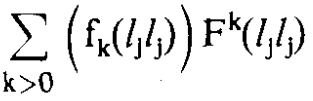
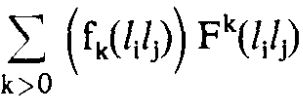
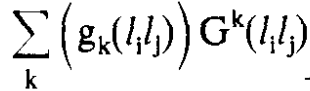

In [ ]:
import numpy as np
from itertools import product


# Example usage format
parseddata = parse.main("ING11_7.txt")
for val in parseddata:
    print(val)



{'Sn13+ 4p64d1': '-1342279.829', 'Sn13+ 4p54d2': '-1341675.369', 'Sn13+ 4p64f1': '-1341615.458'}
{'Sn13+ 4p64d1': ['5675090', '509612'], 'Sn13+ 4p54d2': ['66121100', '10324941', '6993351', '4892892', '511632', '10743513', '13621444', '8610784'], 'Sn13+ 4p64f1': ['72112160', '43382']}
{'4p54d2 - 4p64f1': ['122.26785', '77.73975', '0.00005', '0.00005']}
{'Sn13+ 4p64d1 Sn13+ 4p54d2': ['1.16140(', '4P//R1//', '4D)-0.998hr', '-97'], 'Sn13+ 4p64d1 Sn13+ 4p64f1': ['1.50310(', '4D//R1//', '4F)-0.984hr', '-90']}


In [ ]:
def generate_matrices(J:list, configurations):







    
def generate_matrices(J:list, configurations):
    
    dim = len(J)
    H = np.zeros((dim, dim))

    for i in range(dim):
        for j in range(dim):

            cfg_i = csfs[i]
            cfg_j = csfs[j]

            # === Coulomb Terms ===
            # Direct Slater integrals: F^k
            fk_sum = 0
            for orb1 in orbitals: #these are the open orbitals
                for orb2 in orbitals:
                    li = l_values[orb1]
                    lj = l_values[orb2]
                    for k in fk(li, lj):
                        coeff = fk(li, lj)[k]  # angular part
                        radial = Fk(li, lj)[k]  # radial part
                        fk_sum += coeff * radial

            # Exchange Slater integrals: G^k
            gk_sum = 0
            for orb1 in orbitals:
                for orb2 in orbitals:
                    li = l_values[orb1]
                    lj = l_values[orb2]
                    for k in gk(li, lj):
                        coeff = gk(li, lj)[k]
                        radial = Gk(li, lj)[k]
                        gk_sum += coeff * radial

            # === Spin-Orbit Terms ===
            dj_sum = 0
            for orb in orbitals:
                dj_eta = dj(orb, J, cfg_i, cfg_j)  # matrix element of SO operator for orbital
                dj_sum += dj_eta * zeta[orb]

            # === Combine All Contributions ===
            # Assume Eav is known for this CSF pair (diagonal only)
            if i == j:
                Eav = get_Eav(cfg_i)  # Assume this function exists
            else:
                Eav = 0  # off-diagonal parts do not get Eav

            H[i, j] = Eav + fk_sum + gk_sum + dj_sum

    hamiltonians[J] = H


# Call it like this:
matrices = generate_matrices(parseddata)
#print(matrices)